In [1]:
import plotly.express as px
import pandas as pd
import yfinance as yf
import datetime

In [3]:
def get_sp500_components():
    df = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    df = df[0]
    tickers = df["Symbol"].to_list()
    extended_symbols = ['RIVN', 'AVGO', 'SPY', 'QQQ', 'TSLA', 'MA']
    extended_companies = ['Rivian Automotive', 'Broadcom Inc', 'SPDR S&P 500 ETF', 'Invesco QQQ Trust', 'Tesla', 'Mastercard']
    # Combine tickers with extended symbols
    tickers.extend(extended_symbols)
    ##tickers_companies_dict = dict(zip(df["Symbol"], df["Security"]))
    tickers_companies_dict = dict(zip(df["Symbol"], df["Security"]), **dict(zip(extended_symbols, extended_companies)))
    return tickers, tickers_companies_dict


In [4]:
def load_data(symbol, start, end):
    return yf.download(symbol, start, end)

In [13]:
start_date = datetime.date(2014, 1, 1)
end_date = datetime.date.today()
df = load_data('SPY', start_date, end_date )

[*********************100%%**********************]  1 of 1 completed


In [14]:
temp_df = df.copy()

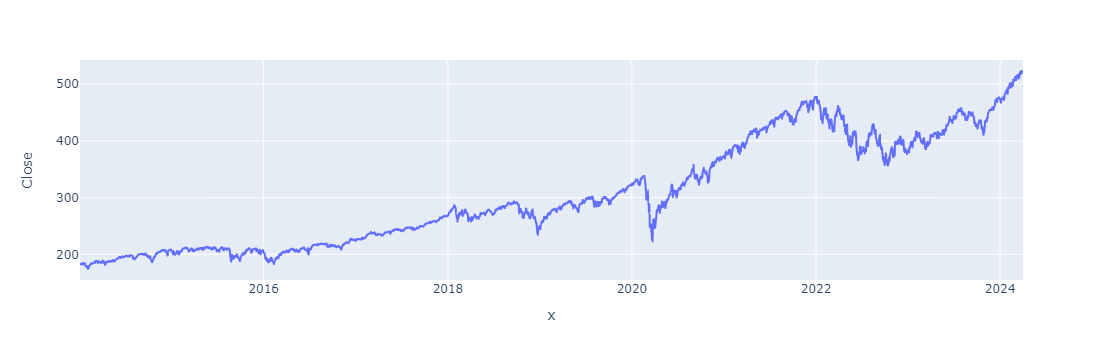

In [15]:
fig = px.line(temp_df, x=df.index, y="Close")
fig.show()

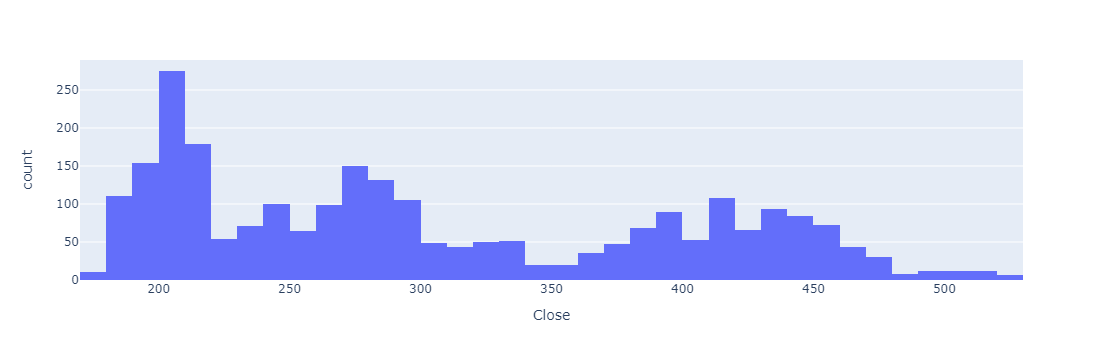

In [17]:
# Find the correct number of bins
fig = px.histogram(df, x="Close")
fig.show()

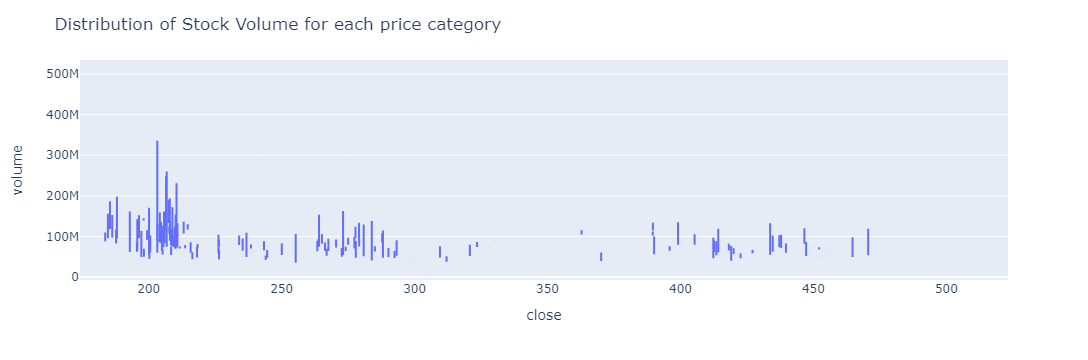

In [27]:
fig = px.box(temp_df, x="Close", y="Volume")

fig.update_layout(
  title="Distribution of Stock Volume for each price category",xaxis_title="close",yaxis_title="volume"
)

fig.show()

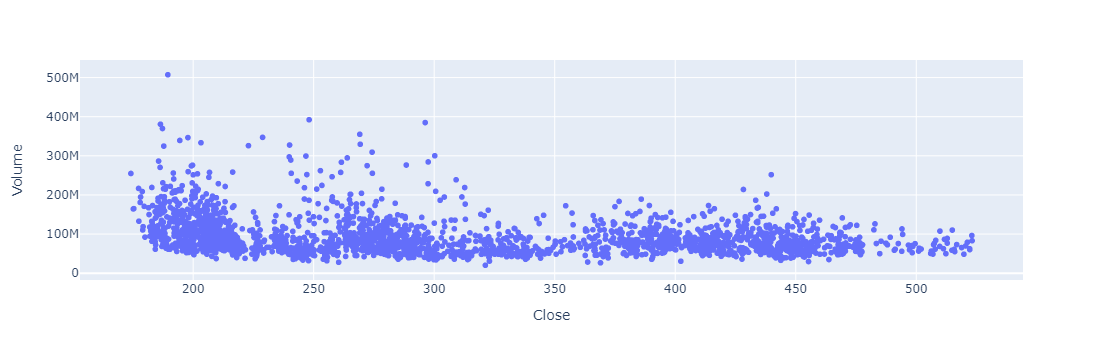

In [28]:
fig = px.scatter(temp_df, x="Close", y="Volume")
fig.show()

In [33]:
import pytz
date_now = int(datetime.datetime.now(pytz.utc).strftime('%d'))
month_now = int(datetime.datetime.now(pytz.utc).strftime('%m'))
year_now = int(datetime.datetime.now(pytz.utc).strftime('%Y'))
time_start = datetime.date(year=min(2010,year_now-10), month=1, day=1) # Take first day and month of 10 years ago / or take first day of 2010
#time_start = datetime.date(year=2014, month=1, day=1)
time_end = datetime.date(year=year_now, month=month_now, day=1) # Take first day of month of today's date

print(time_start)
print(time_end)

2010-01-01
2024-04-01


In [35]:
benchmark =  yf.Ticker('SPY')
benchmark = benchmark.history(period='10y') # Get SPY history data
benchmark.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2014-04-07 00:00:00-04:00,155.400196,155.659264,153.737142,154.054703,140803000,0.0,0.0,0.0
2014-04-08 00:00:00-04:00,153.987829,154.940537,153.427905,154.689835,112660000,0.0,0.0,0.0


In [36]:
benchmark = yf.download('SPY', time_start, time_end)
benchmark.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,86.860069,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,87.089996,111579900


In [37]:
stock_df = yf.download(['SPY', 'AAPL'], period='1d', start=time_start, end=time_end)['Close']
stock_df.head(2)

[*********************100%%**********************]  2 of 2 completed


,AAPL,SPY
Date,,
2010-01-04,7.643214,113.330002
2010-01-05,7.656429,113.629997


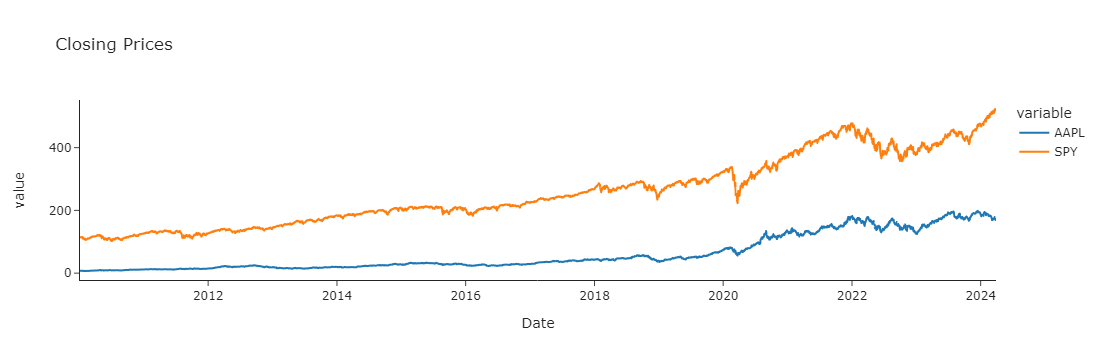

In [75]:
fig = px.line(stock_df, x=stock_df.index, y=stock_df.columns,
             title = 'Closing Prices',           
             template= 'simple_white'
             )
#fig.update_traces(line_color = 'purple')
fig.show()

In [76]:
monthly_prices = stock_df.resample('M').last()
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171 entries, 2010-01-31 to 2024-03-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    171 non-null    float64
 1   SPY     171 non-null    float64
dtypes: float64(2)
memory usage: 4.0 KB


In [111]:
#monthly returns

outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )

In [112]:
#data = data.swaplevel().dropna()
data.head(10)



return_1m  return_2m  return_3m  return_6m  return_9m  \
Date                                                                     
2010-02-28 AAPL   0.065396        NaN        NaN        NaN        NaN   
           SPY    0.031195        NaN        NaN        NaN        NaN   
2010-03-31 AAPL   0.148470   0.106154        NaN        NaN        NaN   
           SPY    0.056529   0.043785        NaN        NaN        NaN   
2010-04-30 AAPL   0.111021   0.129591   0.107774        NaN        NaN   
           SPY    0.015470   0.035796   0.034260        NaN        NaN   
2010-05-31 AAPL  -0.016125   0.045517   0.078766        NaN        NaN   
           SPY   -0.079455  -0.033157  -0.004141        NaN        NaN   
2010-06-30 AAPL  -0.020827  -0.018479   0.022918        NaN        NaN   
           SPY   -0.056231  -0.067915  -0.040910        NaN        NaN   

                 return_12m  
Date                         
2010-02-28 AAPL         NaN  
           SPY          NaN  
2010-03-31 AAPL         NaN  
           SPY          NaN  
2010-04-30 AAPL         NaN  
           SPY          NaN  
2010-05-31 AAPL         NaN  
           SPY          NaN  
2010-06-30 AAPL         NaN  
           SPY          NaN

In [121]:
temp_df = data.reset_index().rename(columns={'level_1': 'Ticker'}).dropna().sort_values(by=['Date','Ticker'],ascending = False)

In [125]:
benchmark_df = temp_df[temp_df['Ticker'] == 'SPY']
ticker_df = temp_df[temp_df['Ticker'] == 'AAPL']


In [126]:
benchmark_df

,Date,Ticker,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
339,2024-03-31,SPY,0.029503,0.040783,0.032431,0.034207,0.018561,0.020631
337,2024-02-29,SPY,0.052187,0.033898,0.036403,0.020306,0.021962,0.020930
335,2024-01-31,SPY,0.015926,0.028601,0.049104,0.008933,0.016722,0.014456
333,2023-12-31,SPY,0.041433,0.066096,0.035986,0.011695,0.016727,0.018284
331,2023-11-30,SPY,0.091344,0.033273,0.004458,0.014817,0.015824,0.009452
...,...,...,...,...,...,...,...,...
31,2011-05-31,SPY,-0.011215,0.008673,0.004362,0.021853,0.027896,0.017637
29,2011-04-30,SPY,0.028961,0.012242,0.019686,0.023775,0.023935,0.011590
27,2011-03-31,SPY,-0.004206,0.015079,0.017812,0.025302,0.028213,0.010478
25,2011-02-28,SPY,0.034737,0.029003,0.039648,0.039869,0.022101,0.015476


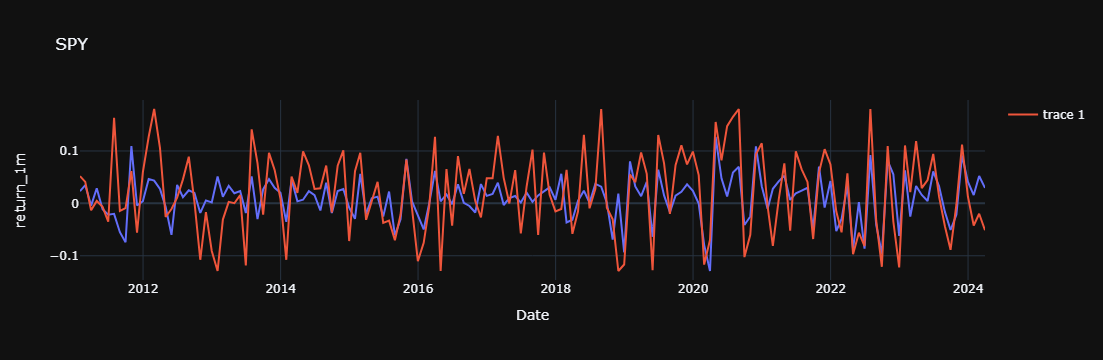

In [134]:
fig = px.line(benchmark_df, x=benchmark_df.Date, y=benchmark_df.return_1m,
             title = 'SPY',           
             template= 'plotly_dark'
             )
#fig.update_traces(line_color = 'purple')
fig.add_scatter(x=ticker_df.Date, y=ticker_df.return_1m,mode='lines')
fig.show()

In [99]:
import pandas as pd
import plotly.express as px

# Assuming df is your DataFrame
# Read the DataFrame
data = df1
# Melt the DataFrame to have 'Date' and 'level_1' as id_vars
melted_df = pd.melt(df, id_vars=['Date', 'level_1'], var_name='Return_Period', value_name='Return')

# Calculate cumulative returns
melted_df['Cumulative_Return'] = melted_df.groupby(['level_1', 'Date'])['Return'].cumsum()

melted_df.head(10)


,Date,level_1,Return_Period,Return,Cumulative_Return
0,2011-01-31,AAPL,return_1m,0.051959,0.051959
1,2011-01-31,SPY,return_1m,0.023300,0.023300
2,2011-01-31,AAPL,return_2m,0.044287,0.096246
3,2011-01-31,SPY,return_2m,0.042113,0.065413
4,2011-01-31,AAPL,return_3m,0.040776,0.137022
5,2011-01-31,SPY,return_3m,0.027882,0.093295
6,2011-01-31,AAPL,return_6m,0.047231,0.184253
7,2011-01-31,SPY,return_6m,0.026067,0.119362
8,2011-01-31,AAPL,return_9m,0.029548,0.213801
9,2011-01-31,SPY,return_9m,0.008906,0.128268
